# Introduction and Set-up

TensorFlow Datasets has many datasets that can be loaded and be used to learn more about image classification and various computer vision machine learning pipelines. It is a great way to learn more about TensorFlow and the architecture of computer vision models in general. This tutorial will go over the importance of data exploration as well as all the steps for a image classification machine learning problem.

In [ ]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_datasets as tfds
# from kaggle_datasets import KaggleDatasets
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import scipy
import gc

try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)
    
print(tf.__version__)

# Initial Exploration

We will be using the TFDS Malaria dataset. The Malaria dataset is contains a total of 27,558 cell images with equal instances of parasitized and uninfected cells from the thin blood smear slide images of segmented cells. The original data source is from [NIH](https://lhncbc.nlm.nih.gov/publication/pub9932). A big aspect of machine learning is data processing. Feature engineering and normalizing data is important. Correctly formatted data will help the model train better and make better inferences about the data.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 16 * strategy.num_replicas_in_sync
IMAGE_SIZE = [180, 180]
EPOCHS = 25

## Loading the data

We'll be using TFDS Malaria dataset for our example. It is quite easy to load the data using TFDS API.

In [ ]:
ds, info = tfds.load('malaria', split='train', shuffle_files=True, with_info=True)

In [ ]:
print("Num classes: " + str(info.features['label'].num_classes))
print("Class names: " + str(info.features['label'].names))

As expected, we have two different classes of images: a "parasitized" class and an "uninfected" class.

## Visualize the data

Let's use the TFDS API to visualize how our images look like.

In [ ]:
vis = tfds.visualization.show_examples(ds, info)

## Feature extraction

Let's convert our images and labels into numpy arrars for our initial analysis.

In [ ]:
train_images = []
train_labels = []

for example in ds:
    train_images.append(example['image'].numpy())
    train_labels.append(example['label'].numpy())

In [ ]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [ ]:
print("Image:")
print(train_images[0])
print("Label: " + str(train_labels[0]))

As we see in our visualizations, not all of the images are of the same size. Additionally, our images, and for most computer vision problems, images will be a 3-channel matrix, meaning 3 matrices are stacked on top of each, one for each color of RGB. Sometimes, features of our image like size, length, and shape can be strong correlations with our labels.

Let's evaluate the length of our images.

In [ ]:
images_flattened = [x.flatten().astype('float64') for x in train_images]

In [ ]:
img_lengths = []

for img in images_flattened:
    img_lengths.append(len(img))

In [ ]:
img_lengths = np.array(img_lengths)

Let's see our the lengths of the images identified as "uninfected" differ from the lengths of the images identifies as "parasitized".

In [ ]:
uninfected_lengths = img_lengths[train_labels]
parasitized_lengths = img_lengths[train_labels == 0]

In [ ]:
scipy.stats.describe(uninfected_lengths)

In [ ]:
plt.scatter(np.arange(len(uninfected_lengths)), uninfected_lengths)

In [ ]:
np.unique(uninfected_lengths)

We see that for the uninfected images, the length of the flattened image array is either 41745 or 54165. Now let's see the lengths of the parasitized images.

In [ ]:
scipy.stats.describe(parasitized_lengths)

In [ ]:
plt.scatter(np.arange(len(parasitized_lengths)), parasitized_lengths)

In [ ]:
np.unique(parasitized_lengths)

For the parasitized lengths, we see that images are a wide variety of lengths. For certain models, having a feature that corresponds with the label can be an issue as the model might assume that the length of an image corresponds with its classification. This will make it difficult to generalize the model as not all uninfected blood smear images are of the same size. To help prevent overfitting and to generalize our model, we will preprocess our images before inputing them.

But first, let's clear some RAM so we don't run out of resources.

In [ ]:
del ds
del info
del train_images
del train_labels
del images_flattened
del img_lengths

gc.collect()

# Model building

## Loading images

We first want to load our images into three different datasets: a training dataset, a validation dataset, and a training dataset.

In [13]:
BATCH_SIZE = 32
IMAGE_SIZE = [200, 200]

train_ds, val_ds, test_ds = tfds.load('malaria',
                                      split=['train[:70%]', 'train[70%:85%]', 'train[85%:]'],
                                      shuffle_files=True, as_supervised=True)

We will divide our data into 70:15:15 ratio. We can check that our ratios are correct by checking how many images are in each dataset.

In [14]:
NUM_TRAIN_IMAGES = tf.data.experimental.cardinality(train_ds).numpy()
print("Num training images: " + str(NUM_TRAIN_IMAGES))

NUM_VAL_IMAGES = tf.data.experimental.cardinality(val_ds).numpy()
print("Num validating images: " + str(NUM_VAL_IMAGES))

NUM_TEST_IMAGES = tf.data.experimental.cardinality(test_ds).numpy()
print("Num testing images: " + str(NUM_TEST_IMAGES))

Num training images: 19291
Num validating images: 4133
Num testing images: 4134


## Reshape image input

Let's see the shapes of our images.

In [15]:
for image, label in train_ds.take(1):
    print("Image shape: ", image.numpy().shape)
    print("Label: ", label.numpy())

Image shape:  (145, 148, 3)
Label:  1


2024-05-11 01:21:43.505042: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Not all the images are of size (200, 200). Thankfully, TensorFlow Image API has a way to resize images by either cropping big pictures or padding smaller ones. Let's define our padding method.

In [16]:
def convert(image, label):
  image = tf.image.convert_image_dtype(image, tf.float32)
  return image, label

def pad(image,label):
  image,label = convert(image, label)
  image = tf.image.resize_with_crop_or_pad(image, 200, 200)
  return image,label

We have to use `.map()` to apply our padding method to all of our images. While we are at it, we should batch our images.

In [17]:
padded_train_ds = (
    train_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

padded_val_ds = (
    val_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

## Visualize padded images

In [18]:
image_batch, label_batch = next(iter(padded_train_ds))

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(10,10))
    for n in range(25):
        ax = plt.subplot(5,5,n+1)
        plt.imshow(image_batch[n])
        if label_batch[n]:
            plt.title("uninfected")
        else:
            plt.title("parasitized")
        plt.axis("off")

2024-05-11 01:22:09.658027: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15360000 exceeds 10% of free system memory.
2024-05-11 01:22:09.738872: W external/local_tsl/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 15360000 exceeds 10% of free system memory.
2024-05-11 01:22:09.767098: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


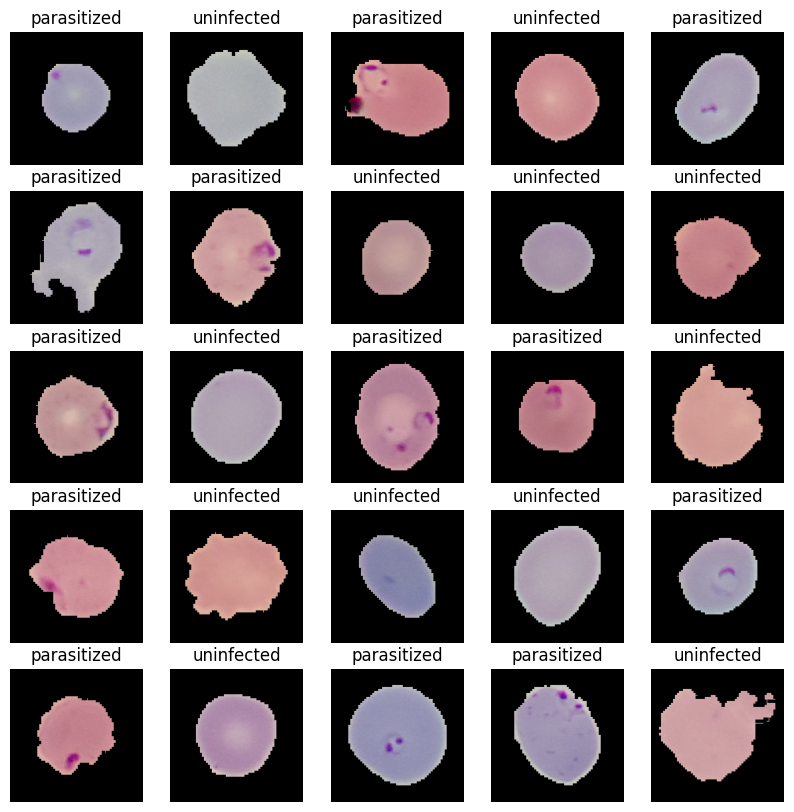

In [19]:
show_batch(image_batch.numpy(), label_batch.numpy())

## Build our model

Let's build our deep CNN. We will be using the TensorFlow Keras API for easy implementation.

We'll create two blocks, one convolution block and one dense block so we won't have to repeat our code.

In [ ]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    
    return block

def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    
    return block

Now we'll define our model. We want our last layer to be a dense layer with a single node. The closer the value is to 1, the higher likelihood that the image is uninfected. Values closer to 0 indice a higher probability of being parasitized.

In [ ]:
def build_model():
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3)),
        
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation='relu', padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    return model

As we are working on a binary classification problem, we will be using a binary crossentropy loss function. Additionally, this data, luckily, is balanced. This means that half of the images are parasitized and half the images are uninfected. Because we are working with a balanced dataset, we will be using AUC-ROC as our metric. To learn more about AUC-ROC, check out this [resource](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc).

In [ ]:
model = build_model()

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=tf.keras.metrics.AUC(name='auc')
)

## Callbacks

We want to define certain callbacks so that we have the best model without overfitting.

One of the most important hyperparameters is the learning rate. A learning rate that is too high will prevent the model from converging. Conversely, a learning rate that is too slow will cause the training process to be too long and take up unnecessary resources. We'll be using an exponential decay function to change our learning rate for each epoch.

The checkpoint and early stopping callback saves the best weights for the model and stops the model once it stops improving. This will slow down overfitting and save time.

In [ ]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("malaria_model.h5",
                                                    save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(patience=5,
                                                     restore_best_weights=True)

def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

## Training

In [ ]:
history = model.fit(
    padded_train_ds, epochs=20,
    validation_data=padded_val_ds,
    callbacks=[checkpoint_cb, early_stopping_cb, lr_scheduler]
)

## Evaluate results

First let's preprocess our testing images.

In [ ]:
padded_test_ds = (
     test_ds
    .cache()
    .map(pad)
    .batch(BATCH_SIZE)
) 

In [ ]:
model.evaluate(padded_test_ds)

We see that our model has an AUC-ROC score of . A high AUC-ROC shows that our model works well at differentiating between parasitized and uninfected cells.

In [ ]:
model.summary()